In [2]:
# Data Visualization
import matplotlib.pyplot as plt

# Data Manipulation
import numpy as np
import pandas as pd

# Word2Vec Loading
import gensim.downloader as api
from gensim.models import KeyedVectors

# Trie for fast lookup
from datrie import BaseTrie
import string

# Dimensionality Reduction
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


from collections import Counter

In [23]:
# Import Google News 300 Word2Vec dataset
w2v_model: KeyedVectors = api.load('word2vec-google-news-300')

In [27]:
# Make a Trie for O(1) lookup of containment of words
t = BaseTrie(string.ascii_lowercase)

for x in w2v_model.index_to_key:
    t[x] = True

In [21]:
# Define a helper function to get the vector of a given word
def vec(str):
    return w2v_model.vectors[w2v_model.key_to_index[str]]

In [37]:
LEN_DATA = 50

country_capital = pd.read_csv('BATS_3.0/3_Encyclopedic_semantics/E01 [country - capital].txt', sep='\t', header=None)
male_female = pd.read_csv('BATS_3.0/3_Encyclopedic_semantics/E10 [male - female].txt', sep='\t', header=None)
animal_young = pd.read_csv('BATS_3.0/3_Encyclopedic_semantics/E06 [animal - young].txt', sep='\t', header=None)
meronyms_member = pd.read_csv('BATS_3.0/4_Lexicographic_semantics/L05 [meronyms - member].txt', sep='\t', header=None)

list_data = [ country_capital, male_female, animal_young, meronyms_member ]

# Add pair_id, which uniquely identifies each pair, and relation_id, which identifies the dataset
full_df = pd.concat([ df.assign(pair_id=range(LEN_DATA*i, LEN_DATA*(i+1)), relation_id=i) for i, df in enumerate(list_data) ])

# Remove all but the first result for the second element of each pair
full_df[1] = full_df[1].str.split('/', expand=True)[0]

# Remove all pairs where one of the words are not in the word2vec dataset
full_df = full_df[full_df[0].apply(t.__contains__) & full_df[1].apply(t.__contains__)]

In [40]:
# Put all of the words in one column, keeping the ids
df = full_df.melt(id_vars=['pair_id', 'relation_id'], value_vars=[0, 1], value_name='word').drop(columns='variable')

In [44]:
# Get vectors for the words (shape 164, 300)
word_vecs = np.vstack(df['word'].apply(vec))

In [46]:
# Get all combinations (indices of a triangular matrix, excluding the diagonal with an offset of 1)
i, j = np.triu_indices(df.shape[0], 1)

In [48]:
# Subtract the words from each other to create a relationship vector
word_pair_vecs = word_vecs[i] - word_vecs[j]

# Half of the vectors will be the wrong way (for example, some will be country-capital, while others will be capital-country)
# They will be on opposite sides of any hyperplane, so we choose a hyperplane and flip everything on the wrong side of it
# Commented out because the way they're paired right now, this never happens
# word_pair_vecs[word_pair_vecs[:, 0] < 0] = -word_pair_vecs[word_pair_vecs[:, 0] < 0]

In [54]:
word_pairs = pd.DataFrame([df['word'][i].reset_index(drop=True), df['word'][j].reset_index(drop=True)], index=['word1', 'word2']).T

In [217]:
from umap import UMAP
pipe = Pipeline([
    ('scaler', StandardScaler()),
    # ('dim_reduce', UMAP(n_components=2, n_neighbors=5, random_state=42)),
    ('dim_reduce', PCA(n_components=2, random_state=42))
])

transform = pipe.fit_transform(word_pair_vecs[valid_pairs])

In [84]:
valid_pairs = df.loc[i, 'pair_id'].reset_index(drop=True) == df.loc[j, 'pair_id'].reset_index(drop=True)
cc_cond = (df.loc[i, 'relation_id'].reset_index(drop=True) == 0) & (df.loc[j, 'relation_id'].reset_index(drop=True) == 0)
mf_cond = (df.loc[i, 'relation_id'].reset_index(drop=True) == 1) & (df.loc[j, 'relation_id'].reset_index(drop=True) == 1)
ay_cond = (df.loc[i, 'relation_id'].reset_index(drop=True) == 2) & (df.loc[j, 'relation_id'].reset_index(drop=True) == 2)
mm_cond = (df.loc[i, 'relation_id'].reset_index(drop=True) == 3) & (df.loc[j, 'relation_id'].reset_index(drop=True) == 3)

# Find all pairs that make sense; there's a total of 41 + 41 = 82 of them
cc_pairs = transform[valid_pairs & cc_cond]
mf_pairs = transform[valid_pairs & mf_cond]
ay_pairs = transform[valid_pairs & ay_cond]
mm_pairs = transform[valid_pairs & mm_cond]

In [220]:
from sklearn.cluster import DBSCAN


# clusters = DBSCAN(eps=3.5, min_samples=3).fit(transform[valid_pairs])
clusters = KMeans(n_clusters=4, random_state=42).fit(transform)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [237]:
# clusters.labels_
pd.Series(clusters.labels_).value_counts()

1    108
2     43
0     26
3      8
Name: count, dtype: int64

In [238]:
clusters.labels_[cc_cond[valid_pairs]]

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [239]:
pairs = [
    cc_cond,
    mf_cond,
    ay_cond,
    mm_cond,
]
for relationship in pairs:
    print(clusters.labels_[relationship[valid_pairs]])

[0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1]
[1 2 1 1 1 2 1 1 1 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2
 1 1 1 1 2 1 2 2 1 1 1 1]
[0 3 0 3 2 2 0 2 0 2 0 2 2 2 0 2 2 2 0 0 2 1 0 2 2 2 2 0 2 0 3 2 3 0 0 2 1
 3 2 2 0 1 3 2 0 2 3 0 0 3]
[2 1 2 1 1 0 1 1 2 1 1 1 1 2 1 1 1 2 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 2 2 1 1 1 1 0 1]


In [149]:
pd.Series(clusters.labels_).value_counts()

10    10930
8      6850
3      6781
5      6412
13     5469
14     5385
9      4024
1      3990
11     3508
0      3461
7      2662
4      2098
12     2037
6      1896
2      1868
15      894
Name: count, dtype: int64

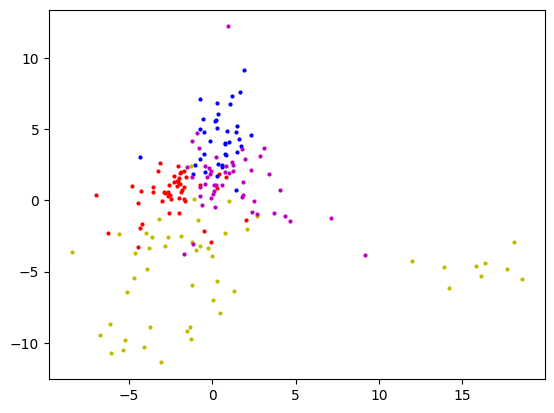

In [218]:
cc_pairs = transform[cc_cond[valid_pairs]]
mf_pairs = transform[mf_cond[valid_pairs]]
ay_pairs = transform[ay_cond[valid_pairs]]
mm_pairs = transform[mm_cond[valid_pairs]]

plt.scatter(transform[:, 0], transform[:, 1], c='k', s=1, label='other')
# plt.scatter(transform[][:, 0], transform[:, 1], c='k', s=0.1, label='other')
plt.scatter(mf_pairs[:, 0], mf_pairs[:, 1], c='r', s=4, label='male/female')
plt.scatter(cc_pairs[:, 0], cc_pairs[:, 1], c='b', s=4, label='country/capital')
plt.scatter(ay_pairs[:, 0], ay_pairs[:, 1], c='y', s=4, label='animal/young')
plt.scatter(mm_pairs[:, 0], mm_pairs[:, 1], c='m', s=4, label='meronyms/member')
# plt.scatter(transform[clusters.labels_ != -1][:, 0], transform[clusters.labels_ != -1][:, 1], c=clusters.labels_[clusters.labels_ != -1], s=4, cmap='viridis', label='clusters')

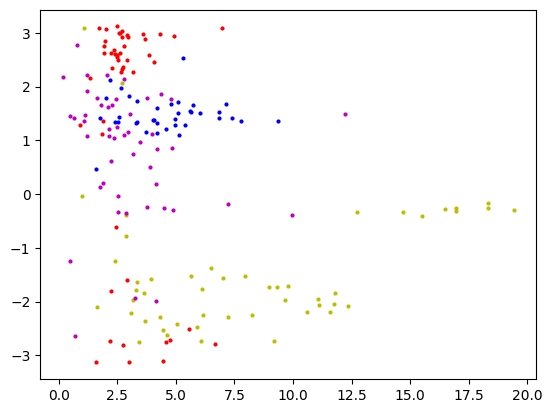

In [234]:
def plot(transform):
    cc_pairs = transform[cc_cond[valid_pairs]]
    mf_pairs = transform[mf_cond[valid_pairs]]
    ay_pairs = transform[ay_cond[valid_pairs]]
    mm_pairs = transform[mm_cond[valid_pairs]]

    plt.scatter(transform[:, 0], transform[:, 1], c='k', s=1, label='other')
    plt.scatter(mf_pairs[:, 0], mf_pairs[:, 1], c='r', s=4, label='male/female')
    plt.scatter(cc_pairs[:, 0], cc_pairs[:, 1], c='b', s=4, label='country/capital')
    plt.scatter(ay_pairs[:, 0], ay_pairs[:, 1], c='y', s=4, label='animal/young')
    plt.scatter(mm_pairs[:, 0], mm_pairs[:, 1], c='m', s=4, label='meronyms/member')

plot(cartesian_to_polar(transform))


In [235]:
clusters = KMeans(n_clusters=4, random_state=42).fit(cartesian_to_polar(transform))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [229]:
import numpy as np

def cartesian_to_polar(points):
    x = points[:, 0]
    y = points[:, 1]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.column_stack((r, theta))

array([[ 6.832627  ,  1.4174051 ],
       [ 4.7905827 ,  1.673763  ],
       [ 5.317832  ,  2.5253434 ],
       [ 4.1777444 ,  1.6040319 ],
       [ 7.159642  ,  1.6736648 ],
       [ 3.006653  ,  1.8179294 ],
       [ 2.1864204 ,  2.117318  ],
       [ 5.077016  ,  1.5138947 ],
       [ 3.7403662 ,  1.1570767 ],
       [ 1.5920688 ,  0.47053778],
       [ 2.407704  ,  1.33688   ],
       [ 9.364719  ,  1.367022  ],
       [ 3.3036036 ,  1.3197721 ],
       [ 4.945354  ,  1.3970565 ],
       [ 6.0515714 ,  1.516725  ],
       [ 5.584428  ,  1.538722  ],
       [ 3.3231235 ,  1.7240089 ],
       [ 7.3866916 ,  1.4136405 ],
       [ 4.0832253 ,  1.3776073 ],
       [ 5.7263045 ,  1.6639653 ],
       [ 3.330184  ,  1.3381732 ],
       [ 2.024135  ,  1.794096  ],
       [ 1.7486414 ,  1.4241189 ],
       [ 4.0235524 ,  1.3866265 ],
       [ 2.6794991 ,  1.9699422 ],
       [ 2.5171833 ,  1.339152  ],
       [ 7.762699  ,  1.3514305 ],
       [ 5.0796576 ,  1.718948  ],
       [ 5.6624184 ,

In [90]:
silhouette_score(word_pair_vecs, clusters.labels_)

0.038430143

In [21]:
pairs = clusters.labels_[i+41 == j]
Counter(pairs)

Counter({1: 45,
         26: 27,
         3: 9,
         2: 8,
         6: 6,
         10: 3,
         4: 2,
         15: 2,
         25: 2,
         30: 1,
         12: 1,
         7: 1,
         13: 1,
         27: 1,
         19: 1,
         11: 1,
         20: 1,
         31: 1,
         24: 1,
         29: 1,
         21: 1,
         22: 1,
         17: 1,
         28: 1,
         0: 1,
         23: 1,
         16: 1,
         18: 1})

In [22]:
total_pairs = pairs.shape

In [23]:
clusters.labels_.shape

(13366,)

In [24]:
def f1_score(precision, recall):
    return 2 * ((precision * recall)/(precision + recall))

In [32]:
def cluster_scorer(estimator):
    
    mf_dict = Counter(estimator.labels_[(i < 82) & (j < 82) & (i+41 == j)])
    cc_dict = Counter(estimator.labels_[(i >= 82) & (j >= 82) & (i+41 == j)])

    mf_cluster, mf_retrieved = mf_dict.most_common(1)[0]
    cc_cluster, cc_retrieved = cc_dict.most_common(1)[0]

    mf_precision = mf_retrieved / word_pairs[estimator.labels_ == mf_cluster].shape[0]
    mf_recall = mf_retrieved / 41

    cc_precision = cc_retrieved / word_pairs[estimator.labels_ == cc_cluster].shape[0]
    cc_recall = cc_retrieved / 41

    mf_f1 = f1_score(mf_precision, mf_recall)
    cc_f1 = f1_score(cc_precision, cc_recall)

    return (mf_f1 + cc_f1) / 2

In [33]:
Counter(clusters.labels_[(i < 82) & (j < 82) & (i+41 == j)])

Counter({1: 34, 30: 1, 12: 1, 7: 1, 13: 1, 27: 1, 19: 1, 11: 1})

In [34]:
cluster_scorer(clusters)

0.03069699240089153

In [35]:
word_pairs[clusters.labels_ == 15]

,word1,word2
4588,nobleman,baron
4589,nobleman,handyman
4590,nobleman,chairman
4591,nobleman,cameraman
4592,nobleman,husband
...,...,...
9265,noblewoman,warsaw
9266,noblewoman,vienna
9267,noblewoman,copenhagen
9268,noblewoman,lima


In [49]:
for i in range(0, 63):
    word_pairs[clusters.labels_==i]

In [65]:
word_pairs[clusters.labels_==0]

,word1,word2
2926,ogre,yogi
2927,ogre,godbrother
2928,ogre,prince
2929,ogre,son
2930,ogre,uncle
...,...,...
3065,ogre,vienna
3066,ogre,copenhagen
3067,ogre,lima
3068,ogre,helsinki


In [21]:
w2v_model.most_similar(positive=['mother', 'businessman'], negative=['father'])

[('businesswoman', 0.7828382849693298),
 ('entrepreneur', 0.5662969946861267),
 ('housewife', 0.5576657056808472),
 ('Businessman', 0.5546095967292786),
 ('woman', 0.5489617586135864),
 ('businesman', 0.5328840017318726),
 ('businessperson', 0.5321270823478699),
 ('resident', 0.5286872982978821),
 ('schoolteacher', 0.5228217244148254),
 ('restaurateur', 0.5167855620384216)]

In [22]:
w2v_model.most_similar(positive=['actress', 'businessman'], negative=['father'])

[('businesswoman', 0.6089984774589539),
 ('actor', 0.5787507891654968),
 ('Actress', 0.5160931348800659),
 ('socialite', 0.48045045137405396),
 ('songstress', 0.47421637177467346),
 ('comedienne', 0.4685734510421753),
 ('actresses', 0.46831855177879333),
 ('thesp', 0.46185967326164246),
 ('politician', 0.45722687244415283),
 ('actress_Andie_MacDowell', 0.4430975317955017)]

In [23]:
w2v_model.most_similar(positive=['actress'])

[('actor', 0.7930010557174683),
 ('Actress', 0.7470887899398804),
 ('actresses', 0.7134618163108826),
 ('actress_Rachel_Weisz', 0.6638520359992981),
 ('Best_Actress', 0.6395923495292664),
 ('singer', 0.6364269852638245),
 ('CATE_BLANCHETT', 0.6363811492919922),
 ('actresss', 0.6308683753013611),
 ('blonde_beauty', 0.6293762922286987),
 ('thesp', 0.6286961436271667)]

In [24]:
w2v_model.similarity('mother', 'actress')

0.42112362

In [25]:
w2v_model.similarity('father', 'businessman')

0.41853

In [28]:
w2v_model.most_similar(positive=['businessman'], negative=['man'])

[('entrepreneur', 0.42547309398651123),
 ('businessmen', 0.42060863971710205),
 ('George_Behrakis', 0.40702372789382935),
 ('industrialist', 0.39802905917167664),
 ('wealthy_businessman', 0.3973967134952545),
 ('Beijing_AustChina_Technology', 0.390698105096817),
 ('venture_capitalist', 0.39069175720214844),
 ('tycoon', 0.3837265968322754),
 ('Businessman', 0.3836364448070526),
 ('Louis_Beecherl', 0.38110217452049255)]

In [27]:
male_female_model

,maleL,femaleL
4,businessman,businesswoman
5,emperor,empress
6,actor,actress
7,brother,sister
8,king,queen
11,newspaperman,newspaperwoman
16,prior,prioress
23,nephew,niece
24,batsman,batswoman
31,salesman,saleswoman


In [28]:
country_capital_model

,countryLabel,capitalLabel
0,turkey,ankara
1,canada,ottawa
2,australia,canberra
3,england,london
4,iraq,baghdad
5,pakistan,islamabad
6,japan,tokyo
7,israel,jerusalem
8,nigeria,abuja
9,france,paris


In [ ]:
w2v_model.most_similar(positive=[mf_pairs])